# Import Packages and Dataset

In [0]:
%tensorflow_version 2.x

## Packages

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,hamming_loss

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset

Use without stemming and stopword dataset

In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_path = '/content/gdrive/My Drive/Colab Notebooks/TA/dataset/data_train_nostemstop_preprocessed.csv'

data_train = pd.read_csv(train_path,sep=";")

In [5]:
data_train.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,- kdg will be kind enough to show you how to l...,0,1,0,0,0,0,0,0,0,0,0,0,kadang will be kind enough to show you how to...
1,Ternyata komunis juga bisa nangis',0,0,0,0,0,0,0,0,0,0,0,0,ternyata komunis juga bisa menangis
2,USER USER Kenapa harus bom ya? Kek yg benar nu...,0,0,0,0,0,0,0,0,0,0,0,0,user user kenapa harus bom seperti benar men...
3,USER Sumpaaah kaya kalo abis IAA dilanjut olim...,0,0,0,0,0,0,0,0,0,0,0,0,user sumpah kaya kalau habis iya dilanjut olim...
4,RT USER USER USER USER USER fungsi media sosia...,1,0,1,0,0,0,0,0,1,1,0,0,rt user user user user user fungsi media sosia...


In [0]:
test_path = '/content/gdrive/My Drive/Colab Notebooks/TA/dataset/data_test_nostemstop_preprocessed.csv'

data_test = pd.read_csv(test_path,sep=";")

In [7]:
data_test.head()

,Index,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,1,GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO ...,1,1,1,0,0,0,0,0,1,1,0,0,ganteng tapi berengsek buat apa who do you thi...
1,2,Sakit jiwa kali yah..,0,0,0,0,0,0,0,0,0,0,0,0,sakit jiwa kali
2,3,"Does insulting one for being ""Cina"", ""Kafir"", ...",0,1,0,0,0,0,0,0,0,0,0,0,does insulting one for being cina kafir make y...
3,4,USER USER Karena partaimu pdip itu bajingan',1,1,0,1,0,0,0,0,1,0,1,0,user user karena partaimu partai demokrasi ind...
4,5,USER USER Jgn salah itu janji jokowi yg di tun...,1,1,1,0,0,0,0,0,1,1,0,0,user user jangan salah itu janji jokowi di tu...


In [0]:
val_path = '/content/gdrive/My Drive/Colab Notebooks/TA/dataset/data_val_nostemstop_preprocessed.csv'

data_val = pd.read_csv(val_path,sep=";")

In [9]:
data_test.head()

,Index,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,1,GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO ...,1,1,1,0,0,0,0,0,1,1,0,0,ganteng tapi berengsek buat apa who do you thi...
1,2,Sakit jiwa kali yah..,0,0,0,0,0,0,0,0,0,0,0,0,sakit jiwa kali
2,3,"Does insulting one for being ""Cina"", ""Kafir"", ...",0,1,0,0,0,0,0,0,0,0,0,0,does insulting one for being cina kafir make y...
3,4,USER USER Karena partaimu pdip itu bajingan',1,1,0,1,0,0,0,0,1,0,1,0,user user karena partaimu partai demokrasi ind...
4,5,USER USER Jgn salah itu janji jokowi yg di tun...,1,1,1,0,0,0,0,0,1,1,0,0,user user jangan salah itu janji jokowi di tu...


# Features Target Split

In [0]:
X_train = data_train['Tweet_Parsed']
y_train = data_train.drop(['Tweet','Tweet_Parsed'],axis=1)

X_val = data_val['Tweet_Parsed']
y_val = data_val.drop(['Tweet','Tweet_Parsed'],axis=1)

X_test = data_test['Tweet_Parsed']
y_test = data_test.drop(['Tweet','Tweet_Parsed','Index'],axis=1)

# Size of Vocabulary

In [0]:
vocab_size = 5000

In [12]:
vect = Tokenizer(num_words = vocab_size)
vect.fit_on_texts(X_train)
# vocab_size = len(vect.word_index)+1

print(vocab_size)

5000


# Modelling with CNN

## Padding and preparing input sequences

In [13]:
encoded_docs_train = vect.texts_to_sequences(X_train)
padded_docs_train = sequence.pad_sequences(encoded_docs_train,maxlen=100,padding='post')
print(padded_docs_train)

[[938 158  81 ...   0   0   0]
 [346  58  40 ...   0   0   0]
 [  1   1  84 ...   0   0   0]
 ...
 [780 637 297 ...   0   0   0]
 [127   8 494 ...   0   0   0]
 [  9  95  76 ...   0   0   0]]


In [14]:
encoded_docs_val = vect.texts_to_sequences(X_val)
padded_docs_val = sequence.pad_sequences(encoded_docs_val,maxlen=100,padding='post')
print(padded_docs_val)

[[  78  416  161 ...    0    0    0]
 [  78  196  110 ...    0    0    0]
 [  37    1  162 ...    0    0    0]
 ...
 [   1 1211 1211 ...    0    0    0]
 [   1    1  127 ...    0    0    0]
 [   1    1    1 ...    0    0    0]]


In [15]:
encoded_docs_test = vect.texts_to_sequences(X_test)
padded_docs_test = sequence.pad_sequences(encoded_docs_test,maxlen=100,padding='post')
print(padded_docs_test)

[[1013   61  161 ...    0    0    0]
 [ 514 1206  255 ...    0    0    0]
 [ 374  210   39 ...    0    0    0]
 ...
 [ 843 2777  846 ...    0    0    0]
 [   1    1 1102 ...    0    0    0]
 [   1 1731   67 ...    0    0    0]]


## Define Model

In [0]:
model = Sequential()
# Configuring the parameters
model.add(Embedding(vocab_size, output_dim=64, input_length=100))
model.add(Conv1D(128,5, activation="relu"))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation="relu"))
model.add(Dense(12, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           41088     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
Total params: 370,124
Trainable params: 370,124
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [0]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(padded_docs_train, y_train.values, 
                    validation_data=(padded_docs_val, y_val.values),
                    epochs=15, batch_size=256, 
                    verbose=2)

Epoch 1/15
52/52 - 1s - loss: 0.5249 - accuracy: 0.6487 - val_loss: 0.3930 - val_accuracy: 0.1698
Epoch 2/15
52/52 - 1s - loss: 0.3830 - accuracy: 0.3546 - val_loss: 0.3849 - val_accuracy: 0.1698
Epoch 3/15
52/52 - 1s - loss: 0.3782 - accuracy: 0.2614 - val_loss: 0.3800 - val_accuracy: 0.1698
Epoch 4/15
52/52 - 1s - loss: 0.3675 - accuracy: 0.2472 - val_loss: 0.3603 - val_accuracy: 0.2765
Epoch 5/15
52/52 - 1s - loss: 0.3313 - accuracy: 0.4016 - val_loss: 0.3236 - val_accuracy: 0.4667
Epoch 6/15
52/52 - 1s - loss: 0.3044 - accuracy: 0.4576 - val_loss: 0.3172 - val_accuracy: 0.4212
Epoch 7/15
52/52 - 1s - loss: 0.2913 - accuracy: 0.4689 - val_loss: 0.3155 - val_accuracy: 0.4477
Epoch 8/15
52/52 - 1s - loss: 0.2817 - accuracy: 0.4884 - val_loss: 0.3193 - val_accuracy: 0.4171
Epoch 9/15
52/52 - 1s - loss: 0.2720 - accuracy: 0.4918 - val_loss: 0.3182 - val_accuracy: 0.4382
Epoch 10/15
52/52 - 1s - loss: 0.2597 - accuracy: 0.5068 - val_loss: 0.3213 - val_accuracy: 0.4389
Epoch 11/15
52/52 -

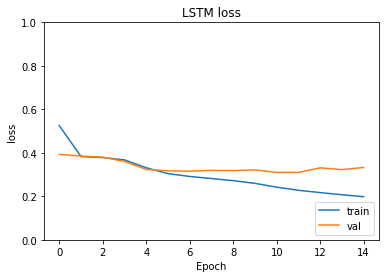

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [0]:
# Final evaluation of the model
scores = model.evaluate(padded_docs_test, y_test.values)

print("Accuracy: %.2f%%" % (scores[1]*100))

115/115 [==============================] - 0s 3ms/step - loss: 0.3086 - accuracy: 0.4535
Accuracy: 45.35%


# Save Model

In [0]:
model.save('/content/gdrive/My Drive/Colab Notebooks/TA/modelCNN_nostemstop.h5')

In [0]:
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/My Drive/Colab Notebooks/TA/Model/5000 vocab/modelCNN_nostemstop.h5')

# Predict and Result

## Predict Data Test

In [0]:
predict = model.predict(padded_docs_test)
predict_train = model.predict(padded_docs_train)
predict_val = model.predict(padded_docs_val)
thresholds=0.5

In [0]:
def labelSetAccuracy(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
#         print('\nset_true: {0}'.format(set_true))
#         print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [0]:
pred_test = predict.copy()
pred_test[pred_test>=0.5] = 1
pred_test[pred_test<0.5] = 0
acc = accuracy_score(y_test.values,pred_test)
haml_loss = hamming_loss(y_test.values,pred_test)
label_acc = labelSetAccuracy(y_test.values,pred_test)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")

threshold =  0.5
exact accuracy =  0.48777173913043476
hamming loss =  0.11743659420289855
label based accuracy =  0.623956931504486


In [20]:
pred_train = predict_train.copy()
pred_train[pred_train>=0.5] = 1
pred_train[pred_train<0.5] = 0
acc = accuracy_score(y_train.values,pred_train)
haml_loss = hamming_loss(y_train.values,pred_train)
label_acc = labelSetAccuracy(y_train.values,pred_train)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")


threshold =  0.5
exact accuracy =  0.5814708547266687
hamming loss =  0.07523532668881507
label based accuracy =  0.7457797601070026


In [21]:
pred_val = predict_val.copy()
pred_val[pred_val>=0.5] = 1
pred_val[pred_val<0.5] = 0
acc = accuracy_score(y_val.values,pred_val)
haml_loss = hamming_loss(y_val.values,pred_val)
label_acc = labelSetAccuracy(y_val.values,pred_val)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")

threshold =  0.5
exact accuracy =  0.4952445652173913
hamming loss =  0.1225090579710145
label based accuracy =  0.6319083203933747


## Analysis Result

### Data Validation Predict Result Analysis

In [0]:
data_val = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).join(y_val).reset_index(drop=True)

In [0]:
data_val.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,so much berengsek people in the world,1,1,0,1,0,0,0,0,1,0,1,0
1,so how can i get my rekening berengsek rekenin...,0,1,0,0,0,0,0,0,0,0,0,0
2,rt user dasar bajingan url,0,1,0,0,0,0,0,0,0,0,0,0
3,user karena kecebong tidak akan mengakui pria ...,1,1,0,1,0,0,0,0,1,0,1,0
4,rt user tidak ada urusannya monyet aku broken ...,1,1,1,0,0,0,0,0,1,1,0,0


In [0]:
data_val_predict = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).reset_index(drop=True).join(pd.DataFrame(data=pred_val, columns=y_val.columns))

In [0]:
data_val_predict.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,so much berengsek people in the world,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,so how can i get my rekening berengsek rekenin...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,rt user dasar bajingan url,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,user karena kecebong tidak akan mengakui pria ...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,rt user tidak ada urusannya monyet aku broken ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Check Number of Label on Predict Data

In [0]:
label_size0_val = []
label_size1_val = []

for i in data_val.columns[1:]:
    label_size0_val.append(len(data_val[data_val[i]==0]))
    label_size1_val.append(len(data_val[data_val[i]==1]))

label_size0_val_predict = []
label_size1_val_predict = []

for i in data_val_predict.columns[1:]:
    label_size0_val_predict.append(len(data_val_predict[data_val_predict[i]==0]))
    label_size1_val_predict.append(len(data_val_predict[data_val_predict[i]==1]))

In [0]:
dat_anls_val = pd.DataFrame({
    'label' : data_val.columns[1:],
    'stats' : ["negative" for i in range(len(data_val.columns[1:]))],
    'jumlah' : label_size0_val
}).append(
    pd.DataFrame({
        'label' : data_val.columns[1:],
        'stats' : ["positive" for i in range(len(data_val.columns[1:]))],
        'jumlah' : label_size1_val
    })
)

# dat_anls_val = dat_anls_val.set_index(['label'], drop=True)

dat_anls_val_predict = pd.DataFrame({
    'label' : data_val_predict.columns[1:],
    'stats' : ["negative" for i in range(len(data_val_predict.columns[1:]))],
    'jumlah' : label_size0_val_predict
}).append(
    pd.DataFrame({
        'label' : data_val_predict.columns[1:],
        'stats' : ["positive" for i in range(len(data_val_predict.columns[1:]))],
        'jumlah' : label_size1_val_predict
    })
)

# dat_anls_val_predict = dat_anls_val_predict.set_index(['label'], drop=True)

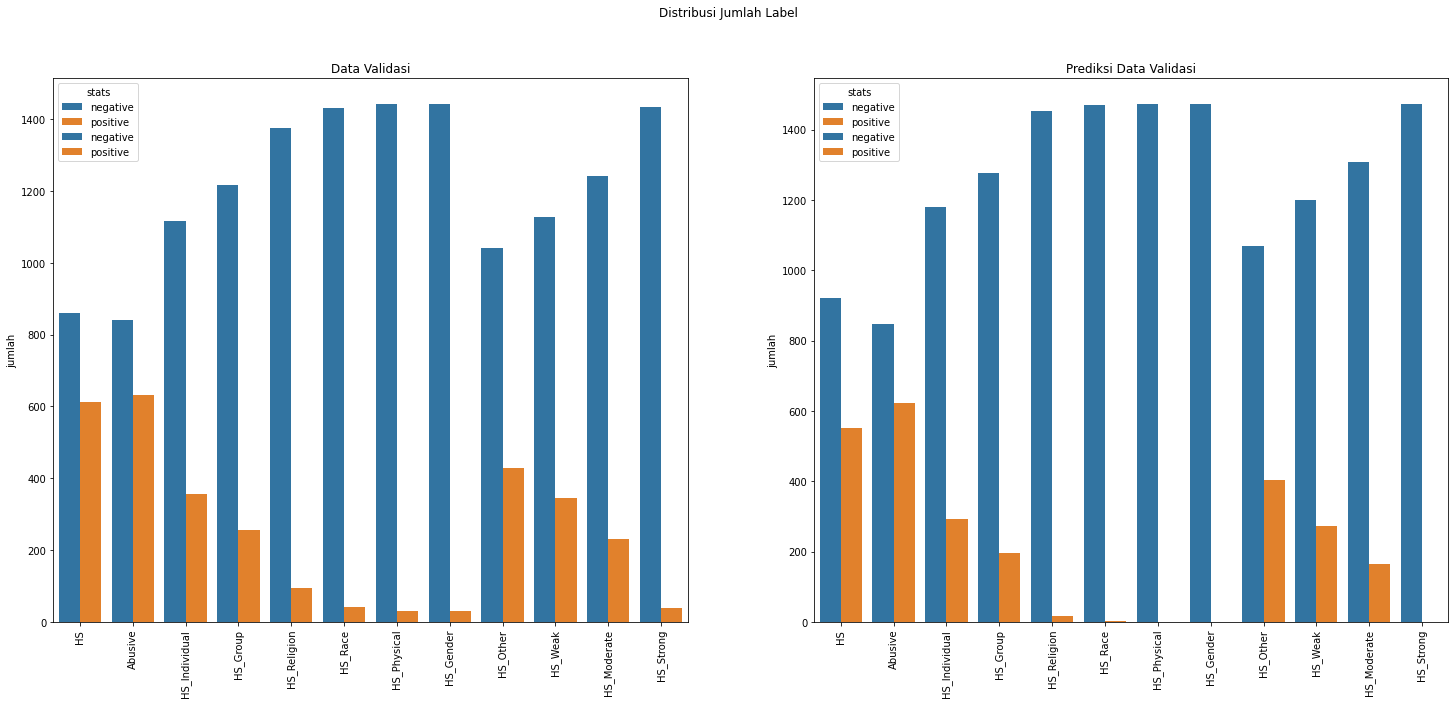

In [0]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).get_xticklabels(),rotation=90)
plt.title("Data Validasi")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Validasi")
plt.xlabel('')

plt.show()

In [0]:
pd.DataFrame({
    "label" : data_val.columns[1:],
    "negative (true)" : dat_anls_val[dat_anls_val['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_val[dat_anls_val['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,859,613,920,552
1,Abusive,840,632,848,624
2,HS_Individual,1115,357,1179,293
3,HS_Group,1216,256,1276,196
4,HS_Religion,1376,96,1454,18
5,HS_Race,1431,41,1469,3
6,HS_Physical,1441,31,1472,0
7,HS_Gender,1441,31,1472,0
8,HS_Other,1042,430,1069,403
9,HS_Weak,1128,344,1199,273


#### OOV Check

In [0]:
def generate_ngrams(s):
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.str.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = np.concatenate(tokens)
    return ngrams

def oov(fitur,token):
    outOfVocab = []
    for i in token:
        if i not in fitur:
            outOfVocab.append(i)
    return outOfVocab

def oov_count(oovList):
    oovCount = {}
    for i in oovList:
        if i in oovCount.keys():
            oovCount[i] = oovCount[i]+1
        else:
            oovCount[i] = 1
    return oovCount

In [0]:
join_data_val = data_val.join(data_val_predict.drop(['Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_val = join_data_val[(join_data_val["HS"]!=join_data_val["HS_predict"]) | (join_data_val["Abusive"] != join_data_val["Abusive_predict"]) | (join_data_val["HS_Individual"] != join_data_val["HS_Individual_predict"]) | (join_data_val["HS_Group"] != join_data_val["HS_Group_predict"]) | (join_data_val["HS_Religion"] != join_data_val["HS_Religion_predict"]) | (join_data_val["HS_Race"] != join_data_val["HS_Race"]) | (join_data_val["HS_Physical"] != join_data_val["HS_Physical_predict"]) | (join_data_val["HS_Gender"] != join_data_val["HS_Gender_predict"]) | (join_data_val["HS_Other"] != join_data_val["HS_Other_predict"]) | (join_data_val["HS_Weak_predict"] != join_data_val["HS_Weak_predict"]) | (join_data_val["HS_Moderate_predict"] != join_data_val["HS_Moderate_predict"]) | (join_data_val["HS_Strong_predict"] != join_data_val["HS_Strong_predict"])]

In [0]:
oov_val = oov(vect.index_word.values(), generate_ngrams(miss_exact_tweet_val['Tweet_Parsed']))
oov_val_count = oov_count(oov_val)

In [0]:
oov_val_count

{'': 1017,
 'ache': 1,
 'adele': 1,
 'adiknya': 1,
 'admirer': 1,
 'advertise': 1,
 'aese': 1,
 'afford': 1,
 'afterwards': 1,
 'aja': 1,
 'akil': 1,
 'akses': 1,
 'aksinya': 1,
 'alia': 1,
 'analysed': 1,
 'ancient': 1,
 'animo': 1,
 'antagonist': 1,
 'apki': 1,
 'apko': 1,
 'apostate': 1,
 'arifinto': 1,
 'armed': 1,
 'arrogance': 1,
 'assaulting': 1,
 'aur': 1,
 'aus': 1,
 'baasyir': 1,
 'bablas': 1,
 'backing': 1,
 'backpass': 2,
 'badassly': 1,
 'baharu': 1,
 'bala': 1,
 'bangsaku': 1,
 'barakat': 1,
 'barter': 1,
 'beheaded': 1,
 'belaganya': 1,
 'bengkok': 2,
 'berbohong': 1,
 'bergaya': 1,
 'bergelimang': 1,
 'bergengsi': 1,
 'berhadap': 1,
 'berhentinya': 1,
 'berlusconi': 1,
 'bermigrasi': 1,
 'berpeci': 1,
 'bertalenta': 1,
 'bertato': 1,
 'berteriaklah': 1,
 'berulah': 1,
 'besanpun': 1,
 'besi': 2,
 'bish': 1,
 'bjp': 3,
 'boikottouslesjours': 1,
 'brag': 1,
 'bragged': 1,
 'brainer': 1,
 'briziek': 1,
 'budhis': 1,
 'budu': 1,
 'buildings': 1,
 'buntel': 1,
 'bunuhlah': 1

In [0]:
print("number of OOV words : ", len(oov_val))
print("number of unique OOV words : ", len(oov_val_count))

number of OOV words :  1566
number of unique OOV words :  520


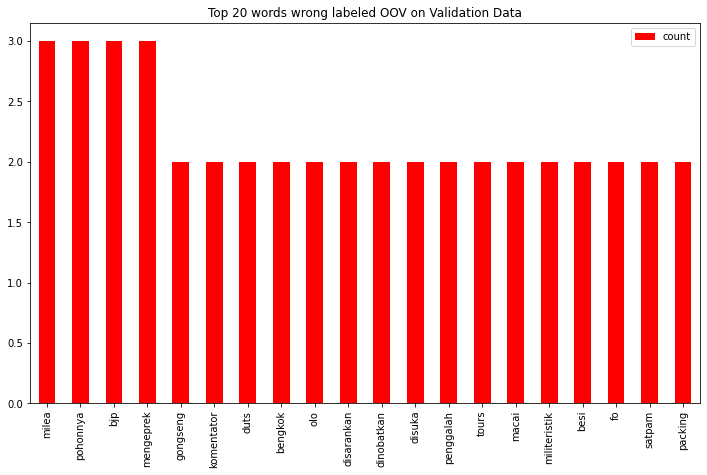

In [0]:
df_oov_val = pd.DataFrame(oov_val_count.items(),columns=["Tweet","count"])
df_oov_val.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

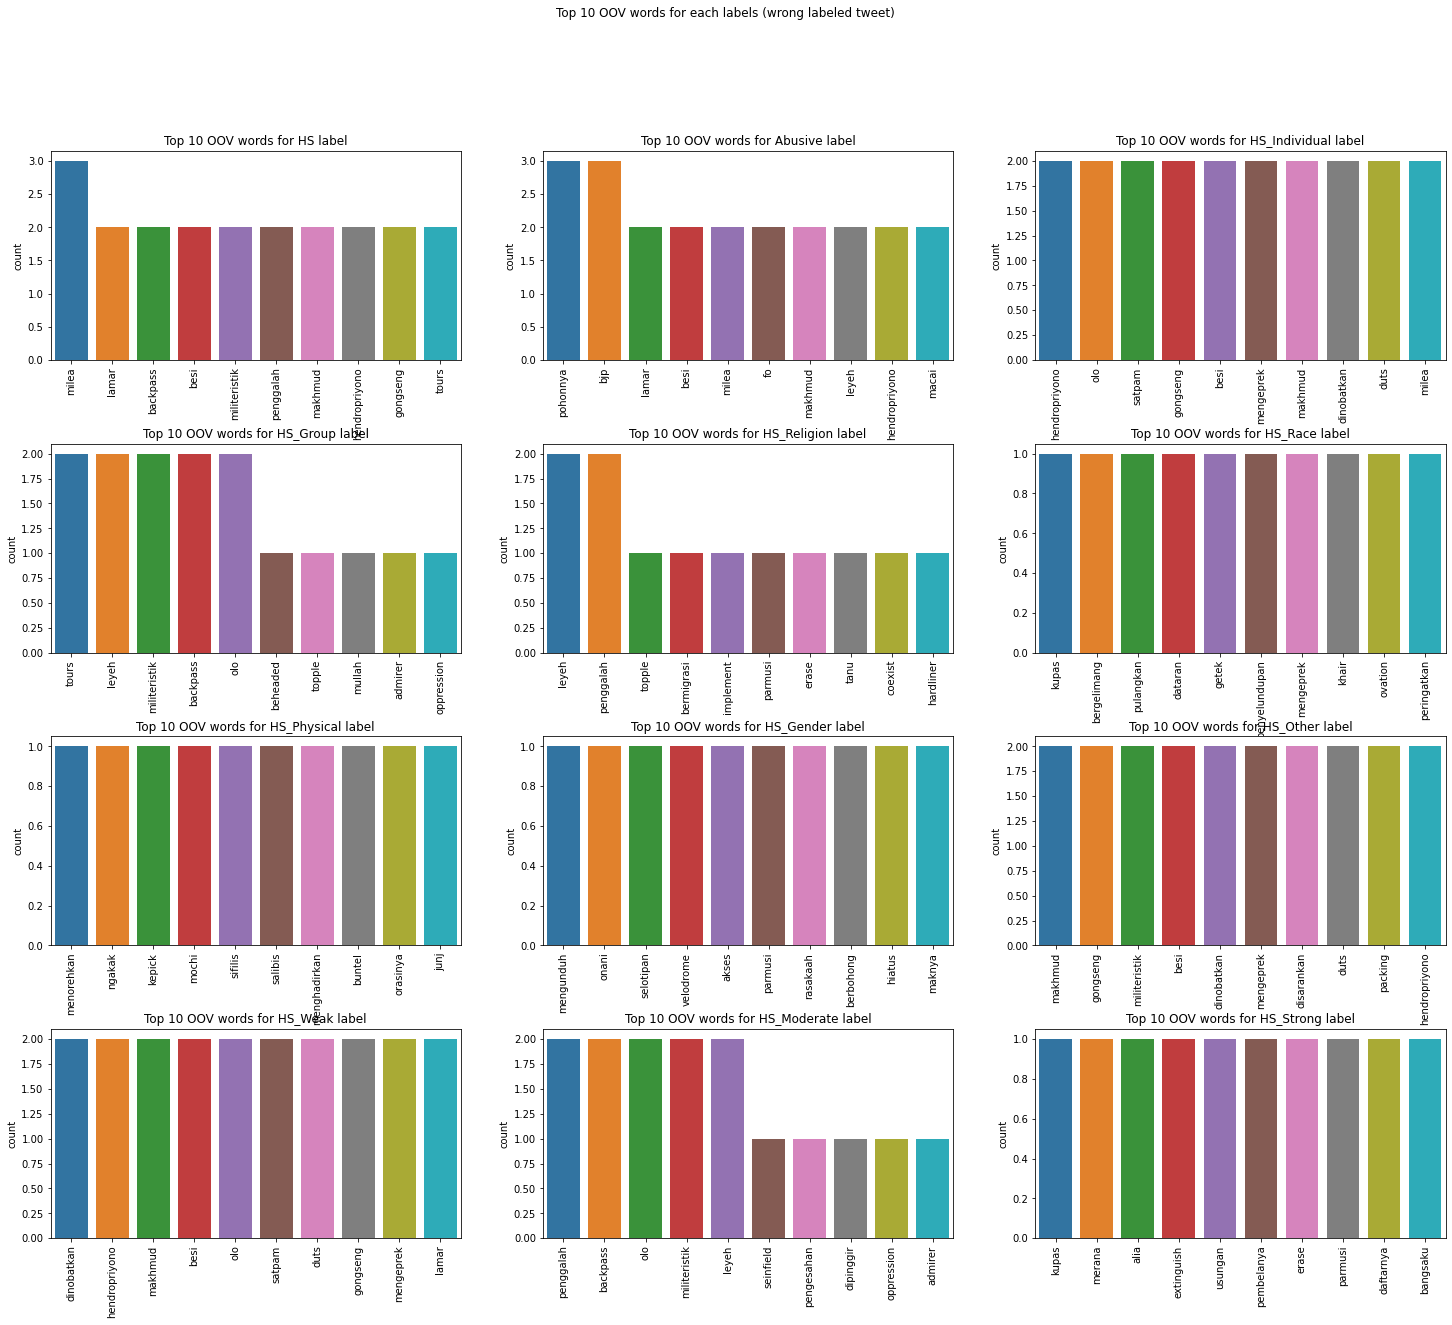

In [0]:
target = y_val.columns

plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_val[join_data_val[target[i]]!=join_data_val[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vect.index_word.values(), wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

#### Tweet Check

In [0]:
miss_exact_tweet_val['Tweet_Parsed'].values.tolist()

['so much berengsek people in the world',
 'rt user dasar bajingan url',
 'user karena kecebong tidak akan mengakui pria lajang  cuma lulusan  sastra sebagai profesor karena untuk disebut profesor anak sampai  tau harus melalui strata pendidikan lagi setelah  itu jawab an kenapa kecebong lebih cerdas dari bani kampret ',
 'rt user tidak ada urusannya monyet aku broken home tidak begitu begitu amat malah dipukuli sama teman teman aku  kaya raya tidak ada tidak ada h ',
 'rt user  tai  tidak ada  mau join tag closed agency basic ',
 'user user aku lagi celeng tidak buat synna emosi jangan mancing  ',
 'user user bacot  kalian ',
 'bahas islam merusak nilai user penguatan karakter melalui revitalisasi pendidikan nilai',
 'user kamu kafir banci   ampun sudah kafir banci lagi jangan sedih  cong kamu google  kafir banci kayak kamu ',
 'user mau naik apa seperti bodoh amat tidak berpengaruh keleees lihat polling google meminta presiden  diganti apa apa apa ganti presiden pak ogah ganti presid

In [0]:
miss_exact_tweet_val.iloc[:,1:-12].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [0]:
miss_exact_tweet_val.iloc[:,-12:].values.tolist()

[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

### Data Test Predict Result Analysis

In [0]:
data_test_predict = pd.DataFrame(data=data_test['Tweet'],columns=['Tweet']).reset_index(drop=True).join(pd.DataFrame(data=pred_test, columns=y_test.columns)).join(pd.DataFrame(data=data_test['Tweet_Parsed'],columns=['Tweet_Parsed']).reset_index(drop=True))

#### Check Number of Label on Predict Data

In [0]:
label_size0_test = []
label_size1_test = []

for i in data_test.columns[2:-1]:
    label_size0_test.append(len(data_test[data_test[i]==0]))
    label_size1_test.append(len(data_test[data_test[i]==1]))

label_size0_test_predict = []
label_size1_test_predict = []

for i in data_test_predict.columns[1:-1]:
    label_size0_test_predict.append(len(data_test_predict[data_test_predict[i]==0]))
    label_size1_test_predict.append(len(data_test_predict[data_test_predict[i]==1]))

In [0]:
dat_anls_test = pd.DataFrame({
    'label' : data_test.columns[2:-1],
    'stats' : ["negative" for i in range(len(data_test.columns[2:-1]))],
    'jumlah' : label_size0_test
}).append(
    pd.DataFrame({
        'label' : data_test.columns[2:-1],
        'stats' : ["positive" for i in range(len(data_test.columns[2:-1]))],
        'jumlah' : label_size1_test
    })
)

# dat_anls_test = dat_anls_test.set_index(['label'], drop=True)

dat_anls_test_predict = pd.DataFrame({
    'label' : data_test_predict.columns[1:-1],
    'stats' : ["negative" for i in range(len(data_test_predict.columns[1:-1]))],
    'jumlah' : label_size0_test_predict
}).append(
    pd.DataFrame({
        'label' : data_test_predict.columns[1:-1],
        'stats' : ["positive" for i in range(len(data_test_predict.columns[1:-1]))],
        'jumlah' : label_size1_test_predict
    })
)

# dat_anls_test_predict = dat_anls_test_predict.set_index(['label'], drop=True)

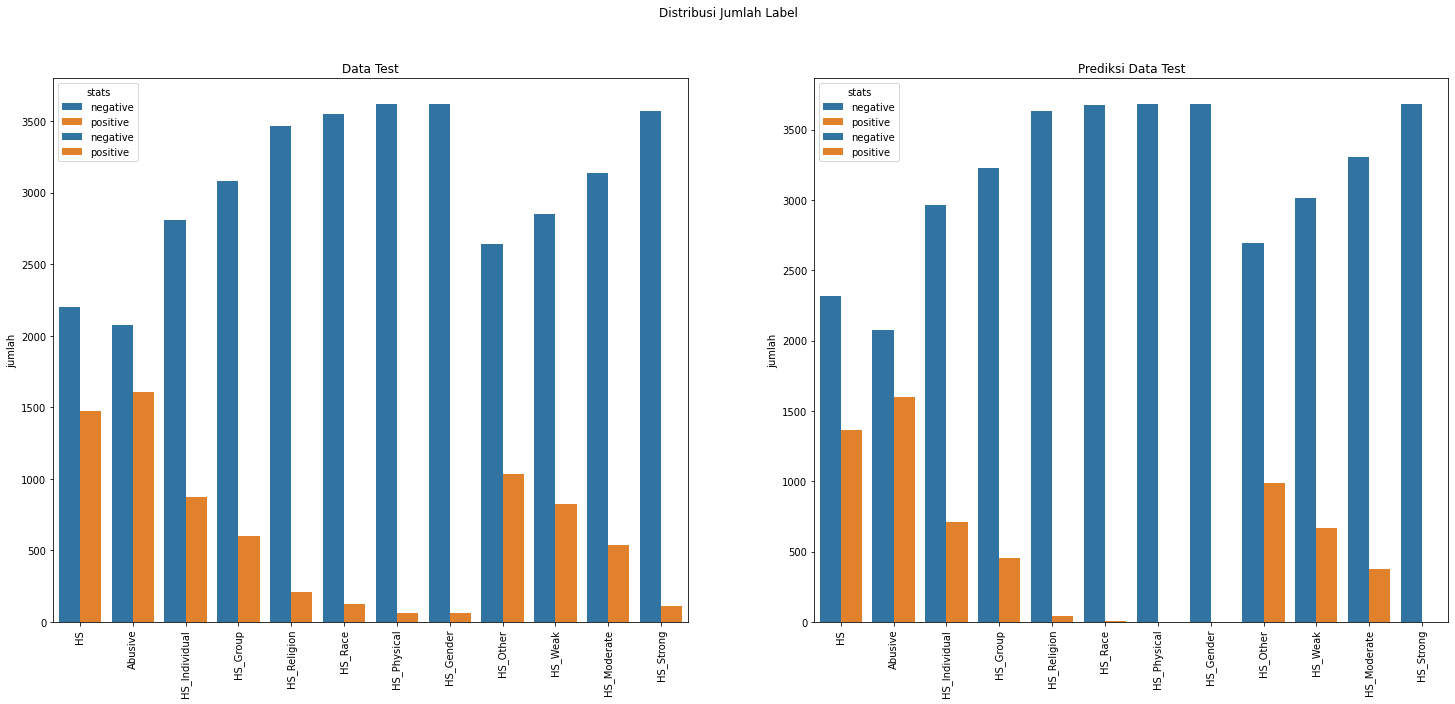

In [0]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).get_xticklabels(),rotation=90)
plt.title("Data Test")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Test")
plt.xlabel('')

plt.show()

In [0]:
pd.DataFrame({
    "label" : data_test.columns[2:-1],
    "negative (true)" : dat_anls_test[dat_anls_test['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_test[dat_anls_test['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,2204,1476,2315,1365
1,Abusive,2075,1605,2077,1603
2,HS_Individual,2806,874,2968,712
3,HS_Group,3078,602,3225,455
4,HS_Religion,3467,213,3635,45
5,HS_Race,3551,129,3672,8
6,HS_Physical,3617,63,3680,0
7,HS_Gender,3616,64,3680,0
8,HS_Other,2643,1037,2691,989
9,HS_Weak,2854,826,3014,666


In [24]:
accuracy_score(join_data_test[join_data_test["HS_Race_predict"]==1]['HS_Race'].tolist(),join_data_test[join_data_test["HS_Race_predict"]==1]['HS_Race_predict'].tolist())

0.75

In [26]:
join_data_test[(join_data_test['HS_Race']==1)&(join_data_test['HS_Race_predict']==1)].shape

(6, 27)

#### OOV Check

In [0]:
join_data_test = data_test.join(data_test_predict.drop(['Tweet','Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_test = join_data_test[(join_data_test["HS"]!=join_data_test["HS_predict"]) | (join_data_test["Abusive"] != join_data_test["Abusive_predict"]) | (join_data_test["HS_Individual"] != join_data_test["HS_Individual_predict"]) | (join_data_test["HS_Group"] != join_data_test["HS_Group_predict"]) | (join_data_test["HS_Religion"] != join_data_test["HS_Religion_predict"]) | (join_data_test["HS_Race"] != join_data_test["HS_Race_predict"]) | (join_data_test["HS_Physical"] != join_data_test["HS_Physical_predict"]) | (join_data_test["HS_Gender"] != join_data_test["HS_Gender_predict"]) | (join_data_test["HS_Other"] != join_data_test["HS_Other_predict"]) | (join_data_test["HS_Weak"] != join_data_test["HS_Weak_predict"]) | (join_data_test["HS_Moderate"] != join_data_test["HS_Moderate_predict"]) | (join_data_test["HS_Strong"] != join_data_test["HS_Strong_predict"])]

In [0]:
oov_test = oov(vect.index_word.values(), generate_ngrams(miss_exact_tweet_test['Tweet_Parsed']))
oov_test_count = oov_count(oov_test)

In [0]:
oov_test_count

{'': 2586,
 'partaimu': 1,
 'cingkrang': 3,
 'memberlakukan': 1,
 'perjudian': 1,
 'hamdalah': 1,
 'suffocating': 1,
 'pollution': 1,
 'distinguished': 1,
 'ngechat': 1,
 'jandro': 1,
 'tangung': 1,
 'setoran': 1,
 'menggila': 1,
 'presidenpun': 1,
 'jongin': 1,
 'frequent': 1,
 'subservient': 1,
 'component': 1,
 'clarifying': 1,
 'vin': 1,
 'pocky': 1,
 'sekop': 1,
 'karbitan': 2,
 'siak': 1,
 'gelapi': 1,
 'bersin': 1,
 'bude': 2,
 'kabah': 1,
 'pentol': 1,
 'banners': 1,
 'polah': 1,
 'dimiskinkan': 1,
 'escalate': 1,
 'menyetop': 1,
 'persi': 1,
 'raganya': 1,
 'sinyalmu': 1,
 'mencuci': 1,
 'bapaknyalah': 1,
 'siwanbango': 1,
 'notulensi': 1,
 'kebayoran': 1,
 'omelan': 1,
 'mengunyah': 1,
 'semrawut': 1,
 'mengambang': 1,
 'critisized': 2,
 'penangite': 1,
 'sheeple': 1,
 'dapig': 1,
 'disregard': 1,
 'confessing': 1,
 'worrying': 1,
 'confessed': 1,
 'longest': 2,
 'reciprocate': 1,
 'qotd': 1,
 'praying': 2,
 'dipolitisasi': 1,
 'tangisan': 1,
 'digentayangi': 1,
 'kegelisahan

In [0]:
print("number of OOV words : ", len(oov_test))
print("number of unique OOV words : ", len(oov_test_count))

number of OOV words :  4164
number of unique OOV words :  1447


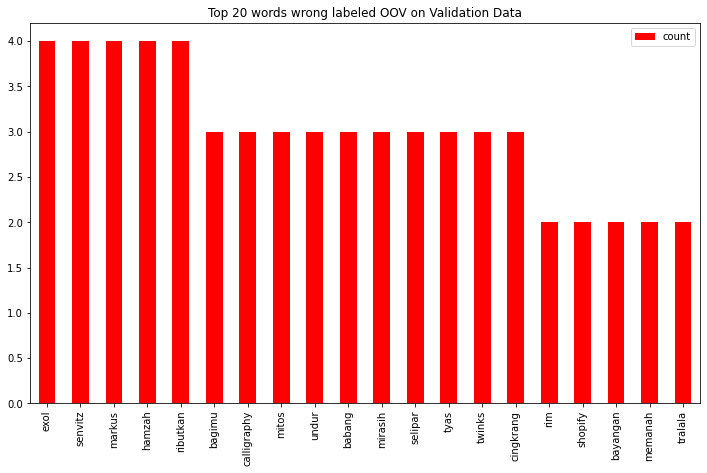

In [0]:
df_oov_test = pd.DataFrame(oov_test_count.items(),columns=["Tweet","count"])
df_oov_test.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

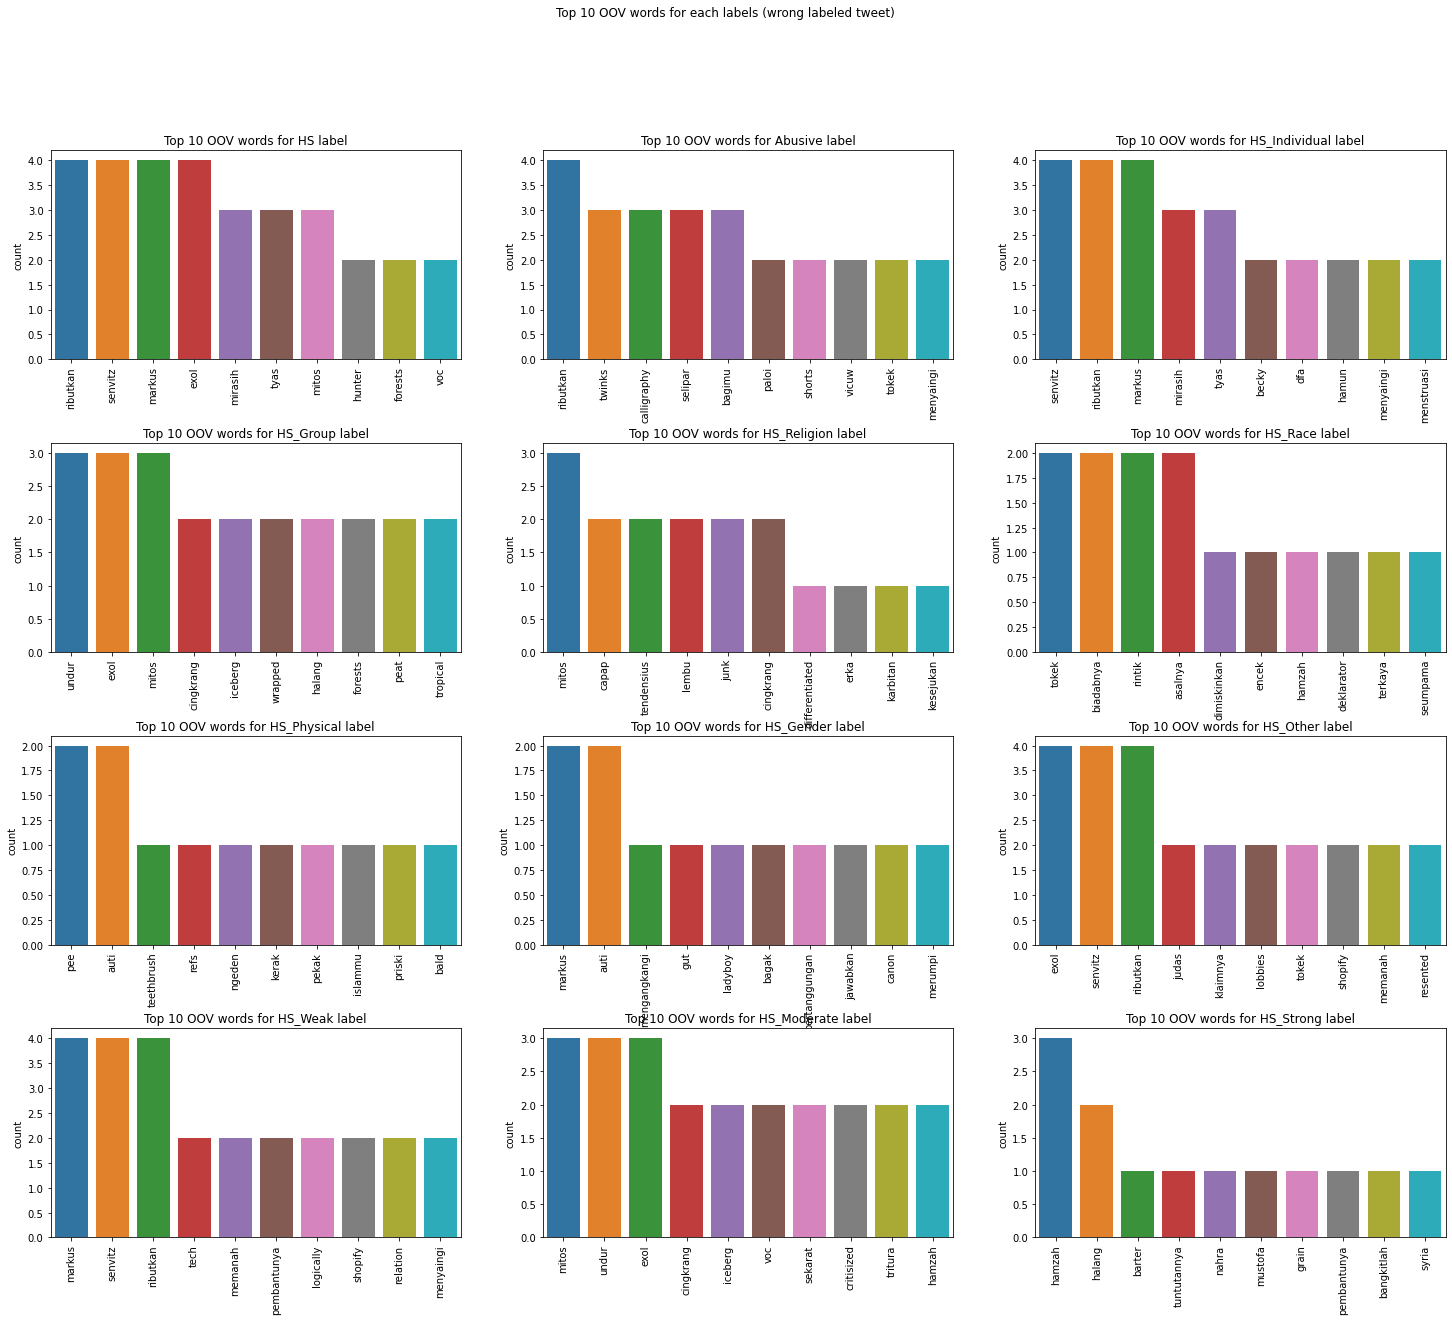

In [0]:
target = y_test.columns

plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_test[join_data_test[target[i]]!=join_data_test[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vect.index_word.values(), wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

#### Tweet Check

In [0]:
miss_exact_tweet_test['Tweet'].values.tolist()

["GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO YOU THINK YOU ARE? YOU'RE NOTHING!! TO ME! << REMEMBER THIS!!",
 'Sakit jiwa kali yah..',
 'Does insulting one for being "Cina", "Kafir", make you a better Muslim?',
 "USER USER Karena partaimu pdip itu bajingan'",
 "USER Khan yg ngajarin si garong kafir'",
 "USER Anak pecun... ga jauh2 dr hobi zina.. haha'",
 'USER Udah siap di demo berjilid2 sama bani cingkrang ? Malaysia memberlakukan syariat Islam, tapi melegalkan perjudian dengan berbagai syarat dan ketentuan yg "strict".\'',
 "Hamdalah. Kelar juga ini fitur keparat.'",
 "USER Jancuk! Pingin gue tabok itu anak'",
 "USER USER USER USER USER USER iyain dah tante jablay wkwk'",
 'I like you. You like him, itukan berengsek :3 #nyampah',
 'indonesia: literally suffocating from the air pollution\n\nthe kampungan people watching over their trash burning:  pic.twitter.com/4ny5B7F2uX',
 '#MataNajwaDebatJakarta lucu banget jawaban ahok.. gak nyambung. Ditanya apa di jawab apa. Kena skak mat d 

In [0]:
miss_exact_tweet_test['Tweet_Parsed'].values.tolist()

['ganteng tapi berengsek buat apa who do you think you are you re nothing to me remember this ',
 'sakit jiwa kali  ',
 'does insulting one for being cina kafir make you a better muslim ',
 'user user karena partaimu partai demokrasi indonesia perjuangan itu bajingan ',
 'user   mengajarkan  garong kafir ',
 'user anak pecun tidak jauh jauh dari hobi zina  ',
 'user sudah siap di demo berjilid jilid sama bani cingkrang malaysia memberlakukan syariat islam tapi melegalkan perjudian dengan berbagai syarat dan ketentuan  strict ',
 'hamdalah selesai juga ini fitur keparat ',
 'user jancuk ingin aku tabok itu anak ',
 'user user user user user user iyakan sudah tante jablay  ',
 'i like you you like him itu  berengsek menyampah',
 'indonesia literally suffocating from the air pollution the kampungan people menonton over their sampah burning ',
 ' mata najwa debat jakarta lucu banget jawaban ahok tidak menyambung ditanya apa di jawab apa kena sekak mat di pertanyaan isu agama tadi dasar cin

In [0]:
miss_exact_tweet_test.iloc[:,2:-13].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [0]:
# real label
miss_exact_tweet_test.iloc[:,2:-13].values.tolist()

[[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0,

In [0]:
miss_exact_tweet_test.iloc[:,-12:].values.tolist()

[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0

In [0]:
miss_exact_tweet_test.to_csv("/content/gdrive/My Drive/Colab Notebooks/TA/bestresult_CNN_nostemstop.csv",index=False,sep=";")